<a href="https://colab.research.google.com/github/ysinjab/latent-glitch/blob/main/text_to_image_dalle_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install dependencies

In [ ]:
!pip install -q transformers flax
!pip install -q git+https://github.com/patil-suraj/vqgan-jax.git  # VQGAN model in JAX
!pip install -q git+https://github.com/borisdayma/dalle-mini.git  # Model files

     |████████████████████████████████| 2.9 MB 5.0 MB/s 
     |████████████████████████████████| 193 kB 45.9 MB/s 
     |████████████████████████████████| 3.3 MB 38.7 MB/s 
     |████████████████████████████████| 895 kB 72.3 MB/s 
     |████████████████████████████████| 596 kB 56.0 MB/s 
     |████████████████████████████████| 56 kB 3.8 MB/s 
     |████████████████████████████████| 118 kB 56.3 MB/s 
     |████████████████████████████████| 57 kB 5.0 MB/s 


## Generate encoded images


In [ ]:
from dalle_mini.model import CustomFlaxBartForConditionalGeneration
from transformers import BartTokenizer
import jax
import random
from tqdm.notebook import tqdm, trange

In [ ]:
# make sure we use compatible versions
DALLE_REPO = 'flax-community/dalle-mini'
DALLE_COMMIT_ID = '4d34126d0df8bc4a692ae933e3b902a1fa8b6114'

In [ ]:
# set up tokenizer and model
tokenizer = BartTokenizer.from_pretrained(DALLE_REPO, revision=DALLE_COMMIT_ID)
model = CustomFlaxBartForConditionalGeneration.from_pretrained(DALLE_REPO, revision=DALLE_COMMIT_ID)

Downloading:   0%|          | 0.00/780k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/343 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.66k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.64G [00:00<?, ?B/s]

INFO:absl:Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
INFO:absl:Unable to initialize backend 'gpu': FAILED_PRECONDITION: No visible GPU devices.
INFO:absl:Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.


In [ ]:
# set a prompt
prompt = 'tree'

In [ ]:
# tokenize the prompt
tokenized_prompt = tokenizer(prompt, return_tensors='jax', padding='max_length', truncation=True, max_length=128)
tokenized_prompt

{'input_ids': DeviceArray([[    0, 21512,     2,     1,     1,     1,     1,     1,
                  1,     1,     1,     1,     1,     1,     1,     1,
                  1,     1,     1,     1,     1,     1,     1,     1,
                  1,     1,     1,     1,     1,     1,     1,     1,
                  1,     1,     1,     1,     1,     1,     1,     1,
                  1,     1,     1,     1,     1,     1,     1,     1,
                  1,     1,     1,     1,     1,     1,     1,     1,
                  1,     1,     1,     1,     1,     1,     1,     1,
                  1,     1,     1,     1,     1,     1,     1,     1,
                  1,     1,     1,     1,     1,     1,     1,     1,
                  1,     1,     1,     1,     1,     1,     1,     1,
                  1,     1,     1,     1,     1,     1,     1,     1,
                  1,     1,     1,     1,     1,     1,     1,     1,
                  1,     1,     1,     1,     1,     1,     1,     1,
      

In [ ]:
n_predictions = 8

# create random keys
seed = random.randint(0, 2**32-1)
key = jax.random.PRNGKey(seed)
subkeys = jax.random.split(key, num=n_predictions)
subkeys

DeviceArray([[3475488066, 3337732497],
             [2213593264,   99017213],
             [ 996024363,  132005436],
             [4028617186, 2149756826],
             [1207044572,  914834961],
             [1774770384, 1357552922],
             [ 859372583, 1426185398],
             [2813016642, 3252849339]], dtype=uint32)

In [ ]:
# generate sample predictions
encoded_images = [model.generate(**tokenized_prompt, do_sample=True, num_beams=1, prng_key=subkey) for subkey in tqdm(subkeys)]
encoded_images[0]

  0%|          | 0/8 [00:00<?, ?it/s]

FlaxSampleOutput([('sequences',
                   DeviceArray([[16384,  8867, 13670, 12623, 13670, 13670,  5772, 13670,
                                 10813, 13670,  9377, 11228, 15963,  1536, 13342, 11196,
                                 15575,  8867,  6690,  5772,  7504,  1024,  4815,  5772,
                                  5772, 11492,  5360, 11147,  6605,  8447,  2637,  5791,
                                  3168, 12566, 10813,  5772,  8413, 11941, 14703,  5772,
                                  5772, 13010, 15891, 16226,  5918, 12627,  8583,  9117,
                                  5053,  4090,  5625, 13670,  6690, 15282, 11716,  5722,
                                 14247,  5772, 13010, 12016, 14839, 13543,  5688, 15761,
                                 11656,  3168,  1261,   948,   948,  9043,   948,  8413,
                                  5305,  5305, 16279,  1704,  2514,  8408,  8783, 15945,
                                  2469,  3927,  6243,  5192,  6523, 12026,  15

In [ ]:
# remove first token (BOS)
encoded_images = [img.sequences[..., 1:] for img in encoded_images]
encoded_images[0]

DeviceArray([[ 8867, 13670, 12623, 13670, 13670,  5772, 13670, 10813,
              13670,  9377, 11228, 15963,  1536, 13342, 11196, 15575,
               8867,  6690,  5772,  7504,  1024,  4815,  5772,  5772,
              11492,  5360, 11147,  6605,  8447,  2637,  5791,  3168,
              12566, 10813,  5772,  8413, 11941, 14703,  5772,  5772,
              13010, 15891, 16226,  5918, 12627,  8583,  9117,  5053,
               4090,  5625, 13670,  6690, 15282, 11716,  5722, 14247,
               5772, 13010, 12016, 14839, 13543,  5688, 15761, 11656,
               3168,  1261,   948,   948,  9043,   948,  8413,  5305,
               5305, 16279,  1704,  2514,  8408,  8783, 15945,  2469,
               3927,  6243,  5192,  6523, 12026,  1586, 14037, 13670,
                948,  9206,  1994, 11307, 10295,  6123,  4839, 10121,
               6882, 11211,  1556,  9117, 15076,  5744,  2469,  3037,
               2895, 11306,  3569, 14164,  9035, 15917,  2523,  1972,
               5370,

In [ ]:
encoded_images[0].shape

(1, 256)

## Decode images


In [ ]:
from vqgan_jax.modeling_flax_vqgan import VQModel
import numpy as np
from PIL import Image

In [ ]:
# make sure we use compatible versions
VQGAN_REPO = 'flax-community/vqgan_f16_16384'
VQGAN_COMMIT_ID = '90cc46addd2dd8f5be21586a9a23e1b95aa506a9'

In [ ]:
# set up VQGAN
vqgan = VQModel.from_pretrained(VQGAN_REPO, revision=VQGAN_COMMIT_ID)

DEBUG:filelock:Attempting to acquire lock 140058508299536 on /root/.cache/huggingface/transformers/9d51ab91692e9c42f82e628f71bc27d13685dba2b0b28841dd1fb163e861cb4f.de091ef3cdb74c7d4cc2da0510c99e9ae385befed9ae4473a3191b6d93da9edd.lock
DEBUG:filelock:Lock 140058508299536 acquired on /root/.cache/huggingface/transformers/9d51ab91692e9c42f82e628f71bc27d13685dba2b0b28841dd1fb163e861cb4f.de091ef3cdb74c7d4cc2da0510c99e9ae385befed9ae4473a3191b6d93da9edd.lock


Downloading:   0%|          | 0.00/433 [00:00<?, ?B/s]

DEBUG:filelock:Attempting to release lock 140058508299536 on /root/.cache/huggingface/transformers/9d51ab91692e9c42f82e628f71bc27d13685dba2b0b28841dd1fb163e861cb4f.de091ef3cdb74c7d4cc2da0510c99e9ae385befed9ae4473a3191b6d93da9edd.lock
DEBUG:filelock:Lock 140058508299536 released on /root/.cache/huggingface/transformers/9d51ab91692e9c42f82e628f71bc27d13685dba2b0b28841dd1fb163e861cb4f.de091ef3cdb74c7d4cc2da0510c99e9ae385befed9ae4473a3191b6d93da9edd.lock
DEBUG:filelock:Attempting to acquire lock 140058479321680 on /root/.cache/huggingface/transformers/98190fe7878f67d122ca4539eb6b459bc77dd757fe54e8cd774952c7f32bab79.8efdbd1ba9de17901e4252a40a48003335296da3f7584ca3cac46bff5d9d142b.lock
DEBUG:filelock:Lock 140058479321680 acquired on /root/.cache/huggingface/transformers/98190fe7878f67d122ca4539eb6b459bc77dd757fe54e8cd774952c7f32bab79.8efdbd1ba9de17901e4252a40a48003335296da3f7584ca3cac46bff5d9d142b.lock


Downloading:   0%|          | 0.00/290M [00:00<?, ?B/s]

DEBUG:filelock:Attempting to release lock 140058479321680 on /root/.cache/huggingface/transformers/98190fe7878f67d122ca4539eb6b459bc77dd757fe54e8cd774952c7f32bab79.8efdbd1ba9de17901e4252a40a48003335296da3f7584ca3cac46bff5d9d142b.lock
DEBUG:filelock:Lock 140058479321680 released on /root/.cache/huggingface/transformers/98190fe7878f67d122ca4539eb6b459bc77dd757fe54e8cd774952c7f32bab79.8efdbd1ba9de17901e4252a40a48003335296da3f7584ca3cac46bff5d9d142b.lock


Working with z of shape (1, 256, 16, 16) = 65536 dimensions.


In [ ]:
# decode images
decoded_images = [vqgan.decode_code(encoded_image) for encoded_image in tqdm(encoded_images)]
decoded_images[0]

  0%|          | 0/8 [00:00<?, ?it/s]

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.


DeviceArray([[[[ 0.3977458 ,  0.5320153 ,  0.60825264],
               [ 0.38989738,  0.56345594,  0.63532925],
               [ 0.39608496,  0.5332344 ,  0.64367956],
               ...,
               [ 0.33780015,  0.43519068,  0.47631913],
               [ 0.3283149 ,  0.44717923,  0.4902748 ],
               [ 0.3836065 ,  0.525649  ,  0.5343505 ]],

              [[ 0.3705102 ,  0.51995087,  0.6135569 ],
               [ 0.40119997,  0.53780824,  0.62922466],
               [ 0.42919415,  0.542916  ,  0.64814985],
               ...,
               [ 0.36268488,  0.44366705,  0.48868668],
               [ 0.32390222,  0.45170158,  0.4791155 ],
               [ 0.35200542,  0.44075716,  0.50700915]],

              [[ 0.3846855 ,  0.54180825,  0.6546563 ],
               [ 0.4210381 ,  0.5537938 ,  0.62703156],
               [ 0.40809602,  0.5429735 ,  0.6390235 ],
               ...,
               [ 0.34035796,  0.44174767,  0.47575307],
               [ 0.33872423,  0.45573294

In [ ]:
# normalize images
clipped_images = [img.squeeze().clip(0., 1.) for img in decoded_images]

In [ ]:
# convert to image
images = [Image.fromarray(np.asarray(img * 255, dtype=np.uint8)) for img in clipped_images]

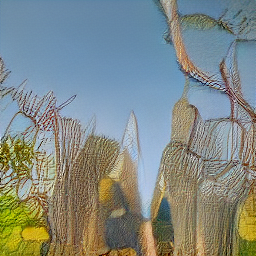

In [ ]:
# display an image
images[0]

In [ ]:
!pwd

/content


Prompt: tree



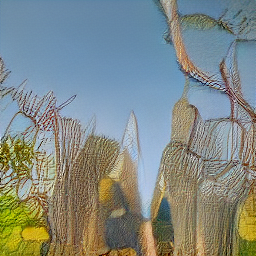

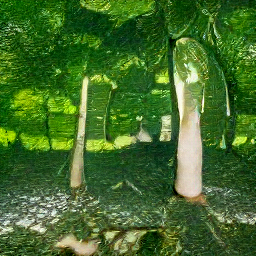

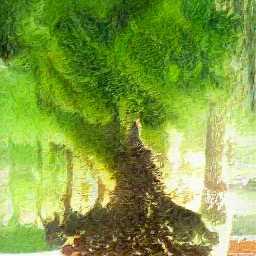

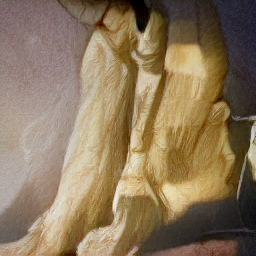

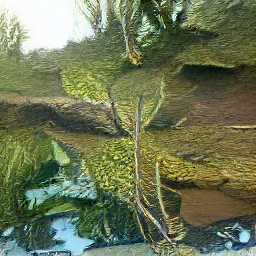

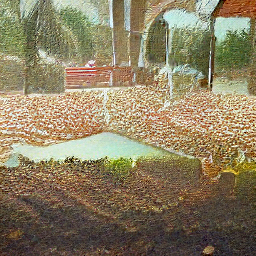

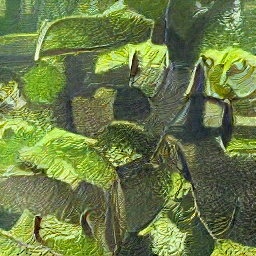

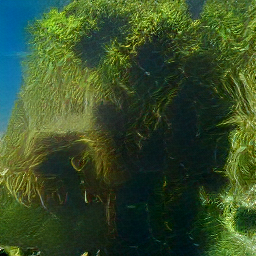

IndexError: ignored

In [ ]:
# rank images by score
print(f'Prompt: {prompt}\n')
for i in range(100):
  images[i].save(f'images/{i}.png')
  display(images[i])
  print()

In [ ]:
!zip -r images.zip images/

  adding: images/ (stored 0%)
  adding: images/0.png (deflated 0%)
  adding: images/4.png (deflated 0%)
  adding: images/5.png (deflated 0%)
  adding: images/1.png (deflated 0%)
  adding: images/7.png (deflated 0%)
  adding: images/6.png (deflated 0%)
  adding: images/2.png (deflated 0%)
  adding: images/3.png (deflated 0%)
